In [23]:
import re
import pandas as pd
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from pyleetspeak.LeetSpeaker import LeetSpeaker, PuntctuationCamouflage, InversionCamouflage
import random

# --- Download necessary NLTK data if not already present ---
try:
    stopwords.words('english')
except LookupError:
    print("Downloading NLTK stopwords...")
    import nltk
    nltk.download('stopwords')

try:
    word_tokenize("test")
except LookupError:
    print("Downloading NLTK punkt...")
    import nltk
    nltk.download('punkt')

try:
    WordNetLemmatizer().lemmatize("testing")
except LookupError:
    print("Downloading NLTK wordnet...")
    import nltk
    nltk.download('wordnet')
# --- End NLTK Downloads Check ---

# --- 1. Load and Preprocess Data ---
csv_file = "./Dataset/labeled_data.csv"
try:
    df = pd.read_csv(csv_file)
except FileNotFoundError:
    print(f"Error: Dataset file not found at {csv_file}. Please check the path.")
    exit()

df = df[['tweet', 'class']].rename(columns={'class': 'label'})
df = df.dropna()

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

offensive_words_list = {
    "2 girls 1 cup", "abbo", "abo", "abortion", "abuse", "addict", "addicts", "adult", "africa", "african", "alla", "allah", "alligatorbait", "amateur", "american", "amp", "anal", "analannie", "analsex", "angie", "angry", "anus", "arab", "arabs", "areola", "areole", "argie", "arian", "armo", "aroused", "arse", "arsebandit", "arsehole", "arrse", "arsewipe", "asanchez", "ass", "assassin", "assassinate", "assassination", "assault", "assbagger", "assbang", "assbanged", "assblaster", "assburger", "assclown", "asscowboy", "asses", "assfuck", "assfucker", "assfukka", "asshat", "asshole", "assholes", "asshore", "assjockey", "asskiss", "asskisser", "assklown", "asslick", "asslicker", "asslover", "assman", "assmonkey", "assmunch", "asspacker", "asspirate", "asspuppies", "assranger", "asswhole", "asswhore", "asswipe", "athletesfoot", "attack", "australian", "autoerotic",
    "babe", "babies", "baby mama", "backdoor", "backdoorman", "backseat", "backstabber", "badfuck", "balllicker", "balls", "ballsack", "banana", "banging", "baptist", "barelylegal", "barf", "barface", "barfface", "bastard", "bastardo", "bastinado", "bayou dweller", "bazongas", "bazooms", "bdsm", "beaner", "beast", "beastial", "beastiality", "beastality", "beatoff", "beat-off", "beatyourmeat", "beaver", "beckie", "beggar", "bellend", "beta male", "betrayer", "bi", "biatch", "bible", "bible thumper", "bicurious", "bigass", "bigbastard", "bigbutt", "bigger", "bimbo", "bimbos", "bisexual", "bi-sexual", "bitch", "bitchass", "bitcher", "bitches", "bitchez", "bitchin", "bitching", "bitchslap", "bitchtits", "bitchy", "biteme", "black", "blackman", "blackout", "blacks", "blabbermouth", "blind", "blockhead", "blood and soil", "blow", "blowjob", "blowjobs", "blue waffle", "bluepilled", "boang", "boche", "bogan", "bohunk", "bollick", "bollock", "bollocks", "bomber", "bombers", "bombing", "bombs", "bomd", "bonehead", "boob", "boobies", "boobs", "booby", "boody", "booobs", "boomer", "boooobs", "booooobs", "booooooobs", "boom", "boonga", "boonie", "bootlicker", "booty", "bootycall", "boss", "boston crab", "bountybar", "bra", "brainlet", "brea5t", "breast", "breastjob", "breastlover", "breastman", "brothel", "brownnoser", "brown shower", "brown showers", "brute", "buceta", "bug chaser", "bugger", "buggered", "buggery", "bukake", "bukkake", "bullcrap", "bulldike", "bulldyke", "bully", "bullshit", "bum", "bumblefuck", "bumfuck", "bumpkin", "bunga", "bunghole", "buried", "burn", "butchbabes", "butchdike", "butchdyke", "butt", "buttbang", "butt-bang", "buttface", "buttfuck", "butt-fuck", "buttfucker", "butt-fucker", "buttfuckers", "butt-fuckers", "butthead", "butthole", "buttlicker", "buttman", "buttmunch", "buttmuncher", "buttpirate", "buttplug", "buttstain", "butterface",
    "cacker", "camel jockey", "cameljockey", "cameltoe", "canadian", "cancer", "carpet muncher", "carpetmuncher", "carruth", "cartel", "catholic", "catholics", "caveman", "cawk", "cemetery", "chad", "charlatan", "chatterbox", "chav", "cheat", "cheese-eating surrender monkey", "cheesehead", "cherrypopper", "chick", "chickslick", "children's", "chin", "chinaman", "chinamen", "chinese", "chink", "chinky", "choad", "chode", "cholo", "christ", "christian", "church", "cigarette", "cigs", "cipa", "claim jumper", "clamdigger", "clamdiver", "clit", "clitoris", "clits", "clogwog", "clown", "clown world", "cnut", "coal burner", "cocaine", "cock", "cockface", "cockfucker", "cockgobbler", "cockhead", "cockmunch", "cockmuncher", "cocks", "cocksplat", "cockstain", "cocksuck", "cocksucked", "cocksucker", "cocksucking", "cocksucks", "cockwaffle", "cockwomble", "coconut", "cohee", "coitus", "cokehead", "cokmuncher", "color", "colored", "coloured", "commie", "communist", "con artist", "condom", "conservative", "conspiracy", "coon", "coondog", "coomer", "copulate", "corn husker", "cornhole", "corruption", "cotton picker", "court jester", "cowboy", "cowgirl", "cowgirls", "cowpoke", "cra5h", "crabs", "crack", "crackhead", "crackpipe", "crackwhore", "crack-whore", "cracker", "cracker ass", "crap", "crapface", "crapola", "crapper", "crappy", "crash", "creamy", "cretin", "crime", "crimes", "criminal", "criminals", "critter", "crotch", "cuck", "cuckservative", "cultist", "cum", "cumbucket", "cumbubble", "cumdumpster", "cumfest", "cumguzzler", "cumjockey", "cuming", "cummer", "cumming", "cumquat", "cumqueen", "cumrag", "cums", "cumshot", "cumstain", "cunilingus", "cunillingus", "cunn", "cunnilingus", "cunntt", "cunt", "cuntface", "cunteyed", "cuntflap", "cuntfuck", "cuntfucker", "cuntlick", "cuntlicker", "cuntlicking", "cunts", "cuntsucker", "curry muncher", "cybersex", "cyberslimer",
    "dago", "dahmer", "damn", "damnation", "damnit", "dunce", "darkie", "darky", "datnigga", "dead", "deadbeat dad", "deapthroat", "death", "deceiver", "deepthroat", "defecate", "dego", "demon", "deplorable", "deposit", "desire", "despot", "destroy", "deth", "devil", "devilworshipper", "dick", "dickbiscuit", "dickbreath", "dickfart", "dickfuck", "dickhead", "dicknose", "dickweasel", "dickwad", "diddle", "die", "died", "dies", "dike", "dildo", "dildos", "dimwit", "dink", "dinks", "dipshit", "dipstick", "dirty", "disease", "diseases", "disturbed", "dive", "dix", "dixiecrat", "dixiedike", "dixiedyke", "dlck", "dog eater", "dog style", "dog-fucker", "doggiestyle", "doggin", "dogging", "doggystyle", "dogwhistle", "dolt", "dong", "donkeyribber", "doomer", "doodoo", "doo-doo", "doom", "doofus", "doosh", "dope", "dope fiend", "dork", "dothead", "double-crosser", "douche", "douchebag", "douchebags", "douchey", "dragqueen", "dragqween", "drifter", "dripdick", "drug", "drunk", "drunken", "duche", "dumb", "dumbass", "dumbbitch", "dumbfuck", "dumbshit", "dumbtwat", "dummy", "dump", "dyefly", "dyke", "dykes",
    "easyslut", "eatadick", "eatballs", "eathairpie", "eatme", "eatpussy", "ecstacy", "egghead", "eggroll", "ejaculate", "ejaculated", "ejaculates", "ejaculating", "ejaculatings", "ejaculation", "ejakulate", "enema", "enemy", "enforcer", "enlargement", "erect", "erection", "ero", "erotic", "erotism", "escort", "essohbee", "ethiopian", "ethnic", "eunuch", "european", "evl", "excrement", "execute", "executed", "execution", "executioner", "extremist",
    "facefucker", "faeces", "fack", "fag", "fag hag", "fagg", "fagged", "fagging", "faggit", "faggitt", "faggot", "faggs", "fagot", "fagots", "fags", "faig", "faigt", "failed", "failure", "fairies", "fairy", "faith", "fanatic", "fanny", "fannybandit", "fannyflaps", "fannyfucker", "fanyy", "fart", "farted", "farting", "fartknocker", "farty", "fashwave", "fashy", "fastfuck", "fat", "fatah", "fatass", "fatfuck", "fatfucker", "fatso", "fcuk", "fcuker", "fcuking", "fear", "feck", "fecker", "feces", "felatio", "felch", "felcher", "felching", "fellate", "fellatio", "feltch", "feltcher", "femdom", "feminazi", "fetish", "field negro", "fight", "filipina", "filipino", "fingerfood", "fingerfuck", "fingerfucked", "fingerfucker", "fingerfuckers", "fingerfucking", "fingerfucks", "fingering", "fink", "fire", "firing", "fish eater", "fisted", "fister", "fistfuck", "fistfucked", "fistfucker", "fistfuckers", "fistfucking", "fistfuckings", "fistfucks", "fisting", "fisty", "flange", "flasher", "flatterer", "flatulence", "flogthelog", "floo", "floozy", "flydie", "flydye", "foad", "fok", "fondle", "fool", "fook", "fooker", "footaction", "footfuck", "footfucker", "footjob", "footlicker", "footstar", "fore", "foreskin", "forni", "fornicate", "foursome", "fourtwenty", "fraud", "freak", "freakfuck", "freakyfucker", "freefuck", "freeloader", "freex", "fried chicken", "frigg", "frigga", "frog", "frontiersman", "fu", "fubar", "fuc", "fucck", "fuck", "fucka", "fuckable", "fuckass", "fuckbag", "fuckbitch", "fuckbucket", "fuckbuddy", "fucked", "fucked up", "fuckedup", "fucker", "fuckers", "fuckface", "fuckfest", "fuckfreak", "fuckfriend", "fuckhole", "fuckhead", "fuckher", "fuckin", "fuckina", "fucking", "fuckingbitch", "fuckings", "fuckingshitmotherfucker", "fuckinnuts", "fuckinright", "fuckit", "fuckknob", "fuckme", "fuckmehard", "fuckmeat", "fuckmonkey", "fucknugget", "fucknut", "fuckoff", "fuckpig", "fuckpuppet", "fucks", "fuckstick", "fucktard", "fucktoy", "fucktrophy", "fuckup", "fuckwad", "fuckwhit", "fuckwhore", "fuckwit", "fuckyou", "fuckyomama", "fudgepacker", "fugly", "fujoshi", "fuk", "fuker", "fukker", "fukkin", "fukking", "fuks", "fukwhit", "fukwit", "fundamentalist", "funeral", "funfuck", "fungus", "futanari", "futanary", "fuuck", "fux", "fuxor", "fxck",
    "gae", "gai", "gaijin", "galaxy brain", "gangbang", "gangbanged", "gangbangs", "gangsta", "ganja", "gassyass", "gatorbait", "gay", "gaylord", "gaymuthafuckinwhore", "gaysex", "geez", "geezer", "geek", "geni", "genital", "german", "getiton", "ghetto", "gey", "gfy", "ghay", "ghey", "gigolo", "gin", "ginzo", "gipp", "git", "gitface", "girls", "givehead", "glans", "glazeddonut", "gob", "god", "godamn", "godamnit", "godammit", "goddam", "goddamit", "goddammit", "goddamn", "goddamned", "goddamnes", "goddamnit", "goddamnmuthafucker", "gokkun", "gold digger", "goldenshower", "gonad", "gonads", "gonorrehea", "gonzagas", "gook", "goon", "gossip", "gotohell", "goy", "goyim", "greaseball", "great replacement", "gringo", "groe", "gross", "grostulation", "gspot", "gtfo", "gubba", "guerrilla", "guido", "gummer", "gun", "gunslinger", "gyp", "gypo", "gypp", "gyppie", "gyppy",
    "half-breed", "hamas", "hamflap", "handjob", "hapa", "hardcoresex", "harder", "hardon", "harem", "hater", "headfuck", "headlights", "heathen", "hebe", "heeb", "hell", "hemp", "henchman", "henhouse", "hentai", "heroin", "herp", "herpes", "herpy", "heshe", "heterosexual", "hick", "hijack", "hijacker", "hijacking", "hillbilly", "hillbillies", "hindoo", "hiscock", "hitler", "hitlerism", "hitlerist", "hiv", "ho", "hoar", "hoare", "hobo", "hobag", "hodgie", "hoe", "hoer", "hoes", "hole", "holestuffer", "holy", "holy roller", "homey", "homewrecker", "homicide", "homo", "homobangers", "homoerotic", "homoey", "homosexual", "honger", "honk", "honkers", "honkey", "honky", "honky tonk", "hooch", "hood rat", "hook", "hookah", "hooker", "hookers", "hoor", "hootch", "hooter", "hooters", "hoosier", "hore", "hork", "horn", "horniest", "horny", "horseshit", "hosejob", "hoser", "hostage", "hotdamn", "hotpussy", "hotsex", "hottotrot", "house negro", "howtokill", "howtomurdep", "hump", "humped", "humping", "hummer", "hun", "husky", "hustler", "hussy", "hymen", "hymie",
    "iblowu", "idiot", "ikey", "illegal", "imbecile", "incel", "inbred", "incest", "infidel", "injun", "insest", "intercourse", "interracial", "intheass", "inthebuff", "introvert", "israel", "israeli", "israel's", "italiano", "itch",
    "jabberjaw", "jackass", "jackhole", "jackoff", "jackshit", "jacktheripper", "jade", "jap", "japo", "japcrap", "japs", "jebus", "jeez", "jerk", "jerked", "jerkoff", "jerry", "jesus", "jesuschrist", "jesus freak", "jew", "jewish", "jiga", "jigaboo", "jigg", "jigga", "jiggabo", "jigger", "jiggy", "jihad", "jihadist", "jijjiboo", "jimfish", "jism", "jiz", "jizm", "jizz", "jizzbag", "jizzed", "jizzstain", "jock", "joint", "juggalo", "jugs", "jungle bunny", "junglebunny", "junkie", "junky",
    "kaffer", "kaffir", "kaffre", "kafir", "kamikaze", "kanake", "karen", "kawk", "kek", "kike", "kill", "kill yourself", "killed", "killer", "killing", "kills", "kinbaku", "kink", "kinky", "kinkyJesus", "kiss-ass", "kissass", "kkk", "klan", "knob", "knobead", "knobed", "knobend", "knobhead", "knobjocky", "knobjokey", "knockers", "know-it-all", "kock", "kondum", "kondums", "kooch", "kooches", "koon", "kool-aid", "kootch", "kotex", "krap", "krappy", "kraut", "kuffar", "kum", "kumbubble", "kumbullbe", "kummer", "kumming", "kumquat", "kums", "kunilingus", "kunnilingus", "kunt", "kwif", "ky", "kyke", "kys",
    "l3itch", "labia", "lackey", "lactate", "ladyboy", "laid", "lapdance", "lapdog", "lardass", "latin", "lawman", "lech", "len", "leper", "lesbain", "lesbayn", "lesbian", "lesbians", "lesbin", "lesbo", "lesbos", "lez", "lezbe", "lezbefriends", "lezbian", "lezbians", "lezbo", "lezbos", "lezzie", "lezzies", "lezzy", "lezzo", "liar", "liberal", "libido", "libtard", "licker", "lickme", "lies", "limey", "limpdick", "limy", "lingerie", "liquor", "livesex", "lmao", "lmfao", "loadedgun", "loin", "loins", "lolita", "loner", "looser", "loser", "lotion", "loudmouth", "lovebone", "lovegoo", "lovegun", "lovejuice", "lovemuscle", "lovepistol", "loverocket", "lowlife", "lsd", "lube", "lubejob", "lucifer", "luckycammeltoe", "lugan", "lust", "lusting", "lusty", "lynch",
    "m-fucking", "macaca", "mackerel snapper", "mad", "mad scientist", "mafia", "mafugly", "magat", "magicwand", "mams", "mamacita", "manhater", "manpaste", "manslut", "manwhore", "marijuana", "masochist", "massa", "master", "masterb8", "masterbate", "masterbating", "masterbation", "masterbations", "masterblaster", "mastrabator", "masturbate", "masturbating", "masturbation", "mattressprincess", "maxi", "meatbeatter", "meathead", "meatrack", "menses", "menstruate", "menstruation", "mercenary", "meth", "meth head", "meth mouth", "mexican", "mgger", "mggor", "mick", "mickeyfinn", "mideast", "militant", "milf", "mingebag", "minger", "minion", "minority", "misfit", "mockey", "mockie", "mocky", "mofo", "moky", "moles", "molest", "molestation", "molester", "molestor", "mong", "mongrel", "moneyshot", "monkey", "moon cricket", "mooncricket", "moonshiner", "mooch", "moolie", "mormon", "moron", "moslem", "mosshead", "mothafuck", "mothafucka", "mothafuckas", "mothafuckaz", "mothafucked", "mothafucker", "mothafuckers", "mothafuckin", "mothafucking", "mothafuckings", "mothafucks", "motherfuck", "motherfucka", "motherfucked", "motherfucker", "motherfuckers", "motherfuckin", "motherfucking", "motherfuckings", "motherfuckka", "motherfucks", "motherlovebone", "motormouth", "mtherfucker", "mthrfucker", "mthrfucking", "mud shark", "muff", "muffdiver", "muffindiver", "mufflikcer", "muffpuff", "mulatto", "muncher", "munt", "murder", "murderer", "muslim", "mutt", "mutha", "muthafecker", "muthafuckaz", "muthafuckker", "muther", "mutherfucker", "mutherfucking", "muthrfucking",
    "nad", "nads", "naked", "napalm", "nappy", "narc", "narcotic", "nasty", "nastybitch", "nastyho", "nastyslut", "nastywhore", "nazi", "nazism", "neckbeard", "necro", "needthedick", "negro", "negroes", "negroid", "negro's", "neo-nazi", "nerd", "newb", "nig", "niger", "nigerian", "nigerians", "nigg", "nigga", "niggah", "niggaracci", "niggard", "niggarded", "niggarding", "niggardliness", "niggardliness's", "niggardly", "niggards", "niggard's", "niggas", "niggaz", "nigger", "niggerhead", "niggerhole", "niggers", "nigger's", "niggle", "niggled", "niggles", "niggling", "nigglings", "niggor", "niggur", "niglet", "nignog", "nigr", "nigra", "nigre", "nimrod", "ninny", "nip", "nipple", "nipples", "nitwit", "nlgger", "nlggor", "nob", "nobjocky", "nobjokey", "nomad", "nonce", "nofuckingway", "nook", "nookey", "nookie", "noonan", "nooner", "normie", "nude", "nudes", "nudger", "nuke", "numbnuts", "numpty", "nutbutter", "nutfucker", "nutjob", "nutsack", "nympho",
    "oddball", "omg", "ontherag", "opiate", "opium", "oral", "orally", "oreo", "organ", "orga", "orgasim", "orgasims", "orgasm", "orgasmic", "orgasms", "orgies", "orgy", "osama", "otaku", "outcast", "outlaw", "overlord", "ovary", "ovum", "ovums", "oxy head",
    "paddy", "paki", "palesimian", "palestinian", "panhandler", "pansy", "pantie", "panties", "panty", "papist", "papi", "pastie", "pasty", "pawn", "payo", "pcp", "pecker", "peckerwood", "pedo", "pedophile", "pedophilia", "pedophiliac", "pee", "peehole", "pee-pee", "peepshow", "peepshpw", "pepega", "pecker", "peckerwood", "pendy", "penetrate", "penetration", "peni5", "penial", "penile", "penis", "penisfucker", "penises", "penthouse", "period", "perversion", "peyote", "phalli", "phallic", "phonesex", "phuck", "phuk", "phuked", "phuking", "phukked", "phukking", "phungky", "phuq", "pi55", "picaninny", "piccaninny", "pickaninny", "piker", "pikey", "piky", "pill popper", "pillock", "pillowbiter", "pimp", "pimpis", "pindick", "pinay", "pinko", "pinoy", "pioneer", "piss", "pissed", "pisser", "pissers", "pisses", "pissflap", "pissflaps", "pisshead", "pissin", "pissing", "pissoff", "pisspot", "pistol", "pixie", "pixy", "playboy", "pms", "pocha", "pocho", "pocketpool", "pohm", "polack", "pollock", "ponce", "poof", "poon", "poontang", "poop", "pooper", "pooperscooper", "pooping", "poorwhitetrash", "popimp", "porch monkey", "porch sitter", "porchmonkey", "porn", "pornflick", "pornking", "porno", "pornography", "pornprincess", "pornos", "possum eater", "possum kicker", "pot", "potty", "poverty", "prat", "premature", "pric", "prick", "prickhead", "prig", "primetime", "pron", "propaganda", "pros", "prostitute", "protestant", "prude", "psycho", "pu55i", "pu55y", "pube", "pubic", "pubiclice", "pubis", "pud", "pudboy", "pudd", "puddboy", "puke", "punkass", "punky", "puntang", "purinapricness", "puss", "pusse", "pussi", "pussies", "pussy", "pussycat", "pussyeater", "pussyfart", "pussyfucker", "pussylicker", "pussylips", "pussylover", "pussypalace", "pussypounder", "pussys", "pusy", "puto",
    "quack", "quashie", "queaf", "queef", "queer", "queero", "queers", "quickie", "quicky", "quim",
    "racy", "ra8s", "rabbi", "race mixer", "race traitor", "racial", "racist", "radical", "radicals", "raghead", "randy", "rape", "raped", "raper", "raping", "rapist", "raunch", "rat", "ratchet", "rearend", "rearentry", "rebel", "recluse", "rectal", "rectum", "rectus", "redlight", "redneck", "reefer", "reestie", "refugee", "reich", "reject", "remains", "rentafuck", "republican", "rere", "retard", "retarded", "revue", "ribbed", "rice nigger", "rice paddy", "rigger", "rimjaw", "rimjob", "rimming", "ritard", "rtard", "roach", "robber", "rodeo clown", "roundeye", "ruffian", "rum", "rumor monger", "rump", "rumprammer", "ruski", "russki", "russkie",
    "sadis", "sadism", "sadist", "sadom", "samckdaddy", "sand nigger", "sandbar", "sandm", "sandnigger", "satan", "sausagequeen", "scag", "scallywag", "scammer", "scantily", "schizo", "schlong", "scout", "screw", "screwed", "screwyou", "scroat", "scrog", "scrot", "scrote", "scrotum", "scrud", "scum", "scumbag", "seaman", "seamen", "seduce", "semen", "seppo", "servant", "settler", "sex", "sexed", "sexfarm", "sexhound", "sexhouse", "sexing", "sexkitten", "sexpot", "sexslave", "sextogo", "sextoy", "sextoys", "sexual", "sexually", "sexwhore", "sexy", "sexymoma", "sexy-slim", "shag", "shagger", "shaggin", "shagging", "shamedame", "shat", "shav", "shawtypimp", "sheep shagger", "sheeney", "she-male", "shemale", "sheriff", "shibari", "shibary", "shhit", "shinola", "shit", "shitbag", "shitbird", "shitcan", "shitcunt", "shitdick", "shite", "shiteater", "shited", "shitey", "shitface", "shitfaced", "shitfit", "shitforbrains", "shitfuck", "shitfucker", "shitfull", "shitgibbon", "shithapens", "shithappens", "shithead", "shithole", "shithouse", "shiting", "shitlist", "shitola", "shitoutofluck", "shits", "shitstain", "shitt", "shitted", "shitter", "shitters", "shittiest", "shitting", "shittings", "shitty", "shitweasel", "shiz", "shoot", "shooting", "shortfuck", "shota", "showtime", "sick", "side chick", "simpleton", "simp", "sissy", "sixsixsix", "sixtynine", "sixtyniner", "sjw", "skag", "skank", "skankbitch", "skankfuck", "skankwhore", "skanky", "skankybitch", "skankywhore", "skel", "skinflute", "skum", "skumbag", "slag", "slant", "slant-eye", "slanteye", "slapper", "slaughter", "slav", "slave", "slavedriver", "sleaze", "sleazebag", "sleazeball", "sleazy", "slideitin", "slime", "slimeball", "slimebucket", "slope", "slopehead", "slopey", "slopy", "slut", "slutbag", "slutbucket", "slutdumper", "slutkiss", "sluts", "slutt", "slutting", "slutty", "slutwear", "slutwhore", "smack", "smackthemonkey", "smart aleck", "smegma", "smoothbrain", "smut", "smutty", "snake oil salesman", "snatch", "snatchpatch", "snigger", "sniggered", "sniggering", "sniggers", "snigger's", "sniper", "snitch", "snot", "snowback", "snownigger", "snowflake", "sob", "sodom", "sodomite", "sodomize", "sodomy", "sodomise", "soldier of fortune", "son-of-a-bitch", "sonofabitch", "sonofbitch", "sooty", "sos", "souse", "soused", "soviet", "soy boy", "spac", "spaghetti bender", "spaghettibender", "spaghettinigger", "spank", "spankthemonkey", "spaz", "spear chucker", "sperm", "spermacide", "spermbag", "spermhearder", "spermherder", "spic", "spick", "spigotty", "spik", "spiks", "spit", "spitter", "splittail", "splooge", "spook", "spooge", "spunk", "spunkbubble", "spunky", "squatter", "squaw", "squarehead", "stacy", "stagg", "steamy", "steelworker", "stfu", "stiffy", "stoned", "stormfag", "strapon", "stringer", "strip", "strip club", "stripclub", "stroke", "suck", "sucked", "suck-up", "sucker", "suckdick", "sucking", "suckme", "suckmyass", "suckmydick", "suckmytit", "suckoff", "suicide", "sumofabiatch", "swallow", "swallower", "swalow", "swastika", "sweetness", "swindler", "sycophant", "syphilis",
    "taboo", "taco bender", "taff", "talkaholic", "tampon", "tang", "tankie", "tantra", "tar baby", "tarbaby", "tard", "tart", "taskmaster", "tattletale", "tawdry", "teabagging", "teacher’s pet", "teat", "teets", "teez", "terd", "terror", "terrorist", "teste", "testee", "testes", "testical", "testicle", "testis", "texas redneck", "thicklips", "thirdeye", "thirdleg", "thot", "threesome", "threeway", "throating", "thrust", "thug", "thunder thighs", "timbernigger", "tinfoil hat", "tinkle", "tit", "titbitnipply", "titfuck", "titi", "titjob", "titlicker", "titlover", "tits", "titt", "tittiefucker", "titties", "titty", "tittyfuck", "tittyfucker", "tittywank", "titwank", "tnt", "toady", "toff", "toke", "toilet", "tongethruster", "tongue", "tonguethrust", "tonguetramp", "toots", "tosspot", "tortur", "torture", "tough guy", "towelhead", "trailblazer", "trailer trash", "trailertrash", "tramp", "transexual", "trannie", "tranny", "transsexual", "transvestite", "trash", "trashy", "trickster", "triggered", "triplex", "trisexual", "trojan", "trots", "truther", "tubgirl", "tuckahoe", "tunneloflove", "turd", "turin", "turnon", "tush", "twat", "twathead", "twats", "twatsack", "twatty", "twatwaffle", "tweaker", "twink", "twinkie", "twit", "twunt", "twunter", "tyrant",
    "uck", "ugly", "uk", "uncle tom", "undies", "unfuckable", "unwed", "upskirt", "uptheass", "upthebutt", "urinal", "urinate", "urine", "usama", "uterus", "uzi",
    "vag", "vagina", "vaginal", "vagrant", "valium", "valley girl", "varmint", "vatican", "vato", "viagra", "vibr", "vibrater", "vibrator", "vietcong", "vigra", "violence", "virgin", "virginbreaker", "vixen", "vodka", "vomit", "voyeur", "vulgar", "vulva",
    "wab", "wad", "wang", "wank", "wanker", "wanking", "wanky", "warlord", "wazoo", "wazzock", "waysted", "weapon", "wedgie", "weed", "weeaboo", "weeb", "weenie", "weewee", "weiner", "weirdo", "welcher", "welfare", "welfare bum", "welfare queen", "wench", "wetb", "wetback", "wetspot", "whacker", "whale", "whash", "whigger", "whiskey", "whiskeydick", "whiskydick", "whit", "white genocide", "white knight", "white trash", "whitenigger", "whites", "whitetrash", "whitey", "whiz", "whoar", "whop", "whore", "whoreface", "whorefucker", "whorehopper", "whorehouse", "whoremonger", "whores", "whoring", "whoralicious", "whorealicious", "whored", "wigger", "willie", "williewanker", "willy", "windbag", "wiseguy", "wn", "wog", "wojak", "woke", "womb", "women's", "woody", "woose", "wop", "worm", "wtf", "wuss", "wuzzie",
    "x-rated2g1c", "xtc", "xx", "xxx",
    "yank", "yankee", "yaoi", "yellow peril", "yellowman", "yes-man", "yokel", "yury",
    "zealot", "zigabo", "zipperhead", "zoomer"
}

WORD_TO_EMOJI_MAP = {
    # === Insults & Slurs ===
    "shit":        ["💩", "🤢"],
    "fuck":        ["🖕", "🍆"],
    "fucking":     ["🖕"],
    "bitch":       ["🐶", "🐩", "💅"],
    "ass":         ["🍑", "🍩"],
    "asshole":     ["🍑", "🚽"],
    "trash":       ["🗑️", "🚮"],
    "jerk":        ["🦍"],
    "clown":       ["🤡"],
    "dumb":        ["🤪", "🙃"],
    "loser":       ["🦆", "🙅‍♂️"],
    "gay":         ["🏳️‍🌈"],
    "monkey":      ["🐒", "🐵"],
    "rat":         ["🐀", "🐭"],
    "snake":       ["🐍"],
    "pig":         ["🐷", "🐖"],
    "cow":         ["🐄", "🐮"],
    "donkey":      ["🐴"],
    "chicken":     ["🐔", "🐤"],
    "dog":         ["🐶", "🐕"],
    "whore":       ["💋", "💃"],
    "slut":        ["👠", "💃"],
    "idiot":       ["🦆", "🤡"],
    "nerd":        ["🤓"],

    # === Explicit Slurs/Racist Emojis (FOR RESEARCH USE) ===
    "nigga":       ["🐵", "🐒"],
    "nigger":      ["🐵", "🐒"],
    "niggah":      ["🐵", "🐒"],
    "coon":        ["🦝"],
    "chink":       ["🥢", "👲"],   # Caution: seen in hate speech context
    "kike":        ["✡️"],
    "spic":        ["🌮"],
    "tranny":      ["👩‍🎤"],      # Commonly used in hate contexts
    "dyke":        ["🌈"],        # May appear in hate or reclaimed contexts

    # === Body Parts & Sexual References ===
    "dick":        ["🍆", "🍌", "🥒"],
    "cock":        ["🐓", "🐔"],
    "pussy":       ["🐱", "🐈", "🌮", "🌸"],
    "tits":        ["🍒", "🍈"],
    "boobs":       ["🍈", "🎈"],
    "balls":       ["⚽", "🏀", "🎱"],
    "cum":         ["💦", "💧"],
    "anus":        ["🍑", "🕳️"],
    "asshole":     ["🍑", "🚽"],
    "fart":        ["💨"],

    # === Actions, Concepts, and Emotions ===
    "kill":        ["🔪", "🔫", "☠️"],
    "murder":      ["🔪", "☠️"],
    "hate":        ["😡", "😠"],
    "sad":         ["😢", "😭"],
    "cry":         ["😭"],
    "love":        ["❤️", "😍", "💖"],
    "fire":        ["🔥"],
    "hot":         ["🔥"],
    "cold":        ["❄️"],
    "money":       ["💰", "💵", "🤑"],
    "rich":        ["💸", "🤑"],
    "poor":        ["💸", "😢"],

    # === Drugs & Alcohol ===
    "weed":        ["🌿", "🍁", "💨"],
    "pot":         ["🍁"],
    "heroin":      ["💉"],
    "meth":        ["💊"],
    "cocaine":     ["❄️"],
    "alcohol":     ["🍺", "🍻", "🥃"],

    # === Miscellaneous ===
    "brain":       ["🧠"],
    "eyes":        ["👀"],
    "skull":       ["💀"],
    "cap":         ["🧢"],  # "No cap" slang
    "star":        ["⭐"],
    "devil":       ["😈"],
    "angel":       ["😇"],

    # === Internet Slang / Soft Replacements ===
    "karen":       ["🙎‍♀️"],
    "simp":        ["🤦‍♂️", "🙇‍♂️"],
    "thot":        ["💃", "👠"],
    "chad":        ["💪"],
    "stacy":       ["💃"],

    # === Add more as needed for your data ===
}


# 2. Character-to-Emoji Mapping (for visual similarity)
CHAR_TO_EMOJI_MAP = {
    'a': ['@', '🅰️', '🔼', 'Λ', '4', 'α', '∂', 'Ʌ'],
    'b': ['🅱️', '₿', 'β', '8', '13', 'ß'],
    'c': ['©', '🅒', 'ↄ', '⊂', '('],
    'd': ['ↁ', '∂', 'ԁ', 'đ'],
    'e': ['3', '📧', '€', 'ε', 'ɘ', '℮'],
    'f': ['🎏', 'ƒ', '₣'],
    'g': ['6', '9', 'ɢ', '🌀'],
    'h': ['#', '♓', 'ħ', '|-|'],
    'i': ['ℹ️', '🇮', '1', '❗', '¡', '|', '丨', 'ɪ'],
    'j': ['¿', 'ĵ', 'ʝ'],
    'k': ['ⲕ', 'Ҝ', 'κ', '|<'],
    'l': ['1', '|', 'ℓ', '🦵'],
    'm': ['♏', 'м', '₥', '/\\/\\'],
    'n': ['♑', 'и', 'ท', '₪', '|\\|'],
    'o': ['⭕', '🅾️', '0️⃣', '0', 'ο', 'θ', '⦿'],
    'p': ['🅿️', 'ρ', '¶', '|*'],
    'q': ['9', '🍳', 'ϙ', 'ԛ'],
    'r': ['®️', 'Я', '₹', 'ɾ'],
    's': ['💲', '⚡', '💰', '$', '5', '§'],
    't': ['✝️', '➕', '7', '+', '†', '☦'],
    'u': ['∪', 'υ', 'µ', 'บ', '[_]'],
    'v': ['✔️', '√', '\\/', 'ν', '∨'],
    'w': ['Ⱳ', 'ω', '\\/\\/', 'Ш'],
    'x': ['❌', '❎', '✖️', '×', '✗', '><'],
    'y': ['¥', 'γ', 'ɣ', 'ʏ'],
    'z': ['2', 'Ⓩ', 'Ⱬ', 'ʐ']
}

### --- END OF NEW SECTION --- ###

def extract_offensive_words_from_tweet(text_tokens, word_list):
    return [token for token in text_tokens if token.lower() in word_list]

processed_tweets, offensive_words_extracted = [], []
for index, row in df.iterrows():
    tweet = str(row['tweet'])
    tweet = re.sub(r'http\S+|@\S+|#\S+|[^\w\s]', '', tweet).lower()
    tokens = [lemmatizer.lemmatize(w) for w in word_tokenize(tweet) if w not in stop_words and re.match(r'^[a-z]+$', w)]
    processed_tweets.append(" ".join(tokens))
    offensive_words_extracted.append(extract_offensive_words_from_tweet(tokens, offensive_words_list))

df['processed_tweet'] = processed_tweets
df['extracted_offensive_words'] = offensive_words_extracted
df_augmented_source = df[df['extracted_offensive_words'].apply(len) > 0].copy()
print(f"Found {len(df_augmented_source)} tweets with offensive words to use as a source for augmentation.")

train_df, temp_df = train_test_split(df_augmented_source, test_size=0.19, random_state=42)
dev_df, test_df = train_test_split(temp_df, test_size=10/19, random_state=42)
print(f"Splitting source data: Train={len(train_df)}, Dev={len(dev_df)}, Test={len(test_df)}")

CAMOUFLAGE_TYPES_TO_APPLY = ["LEETSPEAK", "PUNCT_CAMO", "INV_CAMO", "MIX_CAMO", "EMOJI_CAMO", "EMOJI_CHAR_CAMO"]


def text2emojicharcamo(word, probability=0.5):
    if len(word) < 2: return word
    new_word_list = []
    for char in word:
        if char.lower() in CHAR_TO_EMOJI_MAP and random.random() < probability:
            new_word_list.append(random.choice(CHAR_TO_EMOJI_MAP[char.lower()]))
        else:
            new_word_list.append(char)
    return "".join(new_word_list)
def augment_dataframe_all_combinations(dataframe):
    augmented_data = []
    ls, pc, inv_camo = LeetSpeaker(), PuntctuationCamouflage(), InversionCamouflage()
    print(f"Processing {len(dataframe)} original tweets to generate all combinations...")
    for index, row in dataframe.iterrows():
        original_tweet = row['processed_tweet']
        processed_words_spans = [(m.group(0), m.start(), m.end()) for m in re.finditer(r'\S+', original_tweet)]
        for word_text, start_idx, end_idx in processed_words_spans:
            if word_text.lower() not in offensive_words_list:
                continue
            for camo_type in CAMOUFLAGE_TYPES_TO_APPLY:
                camouflaged_word, label = None, camo_type
                try:
                    if camo_type == 'LEETSPEAK': camouflaged_word = ls.text2leet(word_text)
                    elif camo_type == 'PUNCT_CAMO': camouflaged_word = pc.text2punctcamo(word_text)
                    elif camo_type == 'INV_CAMO': camouflaged_word = inv_camo.text2inversion(word_text, lang='en')
                    elif camo_type == 'MIX_CAMO': camouflaged_word = ls.text2leet(pc.text2punctcamo(word_text))
                    elif camo_type == 'EMOJI_CAMO':
                        emoji_options = WORD_TO_EMOJI_MAP.get(word_text.lower())
                        if emoji_options: camouflaged_word = random.choice(emoji_options)
                    elif camo_type == 'EMOJI_CHAR_CAMO': camouflaged_word = text2emojicharcamo(word_text)
                except Exception as e:
                    continue
                if camouflaged_word and camouflaged_word != word_text:
                    modified_text = original_tweet[:start_idx] + camouflaged_word + original_tweet[end_idx:]
                    new_start, new_end = start_idx, start_idx + len(camouflaged_word)
                    augmented_data.append((modified_text, {"entities": [(new_start, new_end, label)]}))
    return augmented_data

print("\nAugmenting train data with all combinations...")
augmented_train_data = augment_dataframe_all_combinations(train_df)
print("\nAugmenting dev data with all combinations...")
augmented_dev_data = augment_dataframe_all_combinations(dev_df)
print("\nAugmenting test data with all combinations...")
augmented_test_data = augment_dataframe_all_combinations(test_df)

print(f"\n--- DATASET SIZES AFTER EXHAUSTIVE AUGMENTATION ---")
print(f"Generated {len(augmented_train_data)} training examples.")
print(f"Generated {len(augmented_dev_data)} development examples.")
print(f"Generated {len(augmented_test_data)} testing examples.")

def save_augmented_data_to_csv(data, file_path):
    records = []
    for text, ann in data:
        for start, end, label in ann.get("entities", []):
            records.append({"Text": text, "Entity": text[start:end], "Label": label, "Start": start, "End": end})
    df = pd.DataFrame(records)
    if not df.empty:
        df.to_csv(file_path, index=False, encoding='utf-8-sig')
        print(f"Saved {len(df)} records to {file_path}")
    else:
        print(f"No data to save for {file_path}")

save_augmented_data_to_csv(augmented_train_data, "augmented_train_all_combo_emoji.csv")
save_augmented_data_to_csv(augmented_dev_data, "augmented_dev_all_combo_emoji.csv")
save_augmented_data_to_csv(augmented_test_data, "augmented_test_all_combo_emoji.csv")

print("\n--- Next Steps ---")
print("Your new, much larger CSV files are ready!")
print("1. Use these CSVs as input for your model training script.")
print("2. Remember to add EMOJI_CAMO and EMOJI_CHAR_CAMO to your LABEL_LIST in the training script!")

Found 21862 tweets with offensive words to use as a source for augmentation.
Splitting source data: Train=17708, Dev=1967, Test=2187

Augmenting train data with all combinations...
Processing 17708 original tweets to generate all combinations...


\\?\C:\Users\ASUS\AppData\Roaming\jupyterlab-desktop\jlab_server\Lib\site-packages\pyleetspeak\LeetSpeaker.py:668: RuntimeWarning: You have selected a maximum distance between syllabels (2) for inversion greater than the maximum distance between syllables in the word (1). Reducing `max_dist` maximum distance between syllables.
  warnings.warn(



Augmenting dev data with all combinations...
Processing 1967 original tweets to generate all combinations...

Augmenting test data with all combinations...
Processing 2187 original tweets to generate all combinations...

--- DATASET SIZES AFTER EXHAUSTIVE AUGMENTATION ---
Generated 127080 training examples.
Generated 13934 development examples.
Generated 15681 testing examples.
Saved 127080 records to augmented_train_all_combo_emoji.csv
Saved 13934 records to augmented_dev_all_combo_emoji.csv
Saved 15681 records to augmented_test_all_combo_emoji.csv

--- Next Steps ---
Your new, much larger CSV files are ready!
1. Use these CSVs as input for your model training script.
2. Remember to add EMOJI_CAMO and EMOJI_CHAR_CAMO to your LABEL_LIST in the training script!


Plots will be saved to the 'dataset_visualizations/' directory.

Loaded a total of 156695 augmented examples.
  - Train split: 127080 examples
  - Test split (combined Dev+Test): 29615 examples


C:\Users\ASUS\AppData\Local\Temp\ipykernel_22332\2649229414.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df_all, x='Label', order=df_all['Label'].value_counts().index, palette="viridis")



Generated plot: dataset_visualizations\1_camouflage_type_distribution.png


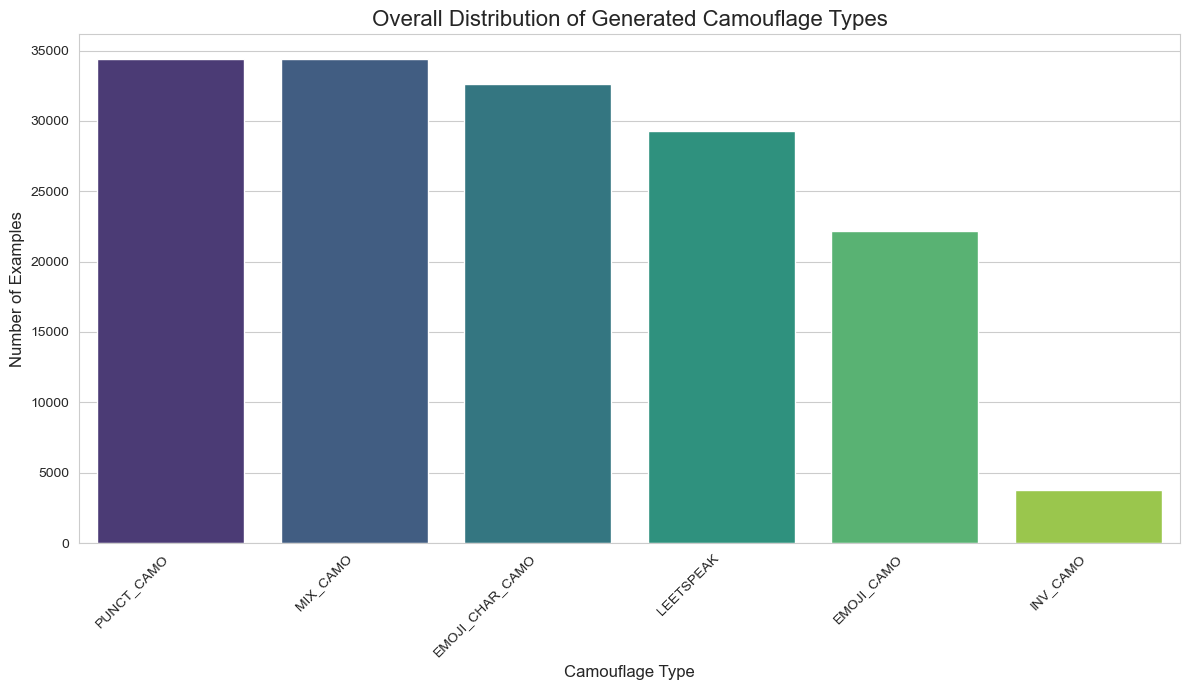

Generated plot: dataset_visualizations\2_distribution_by_split.png


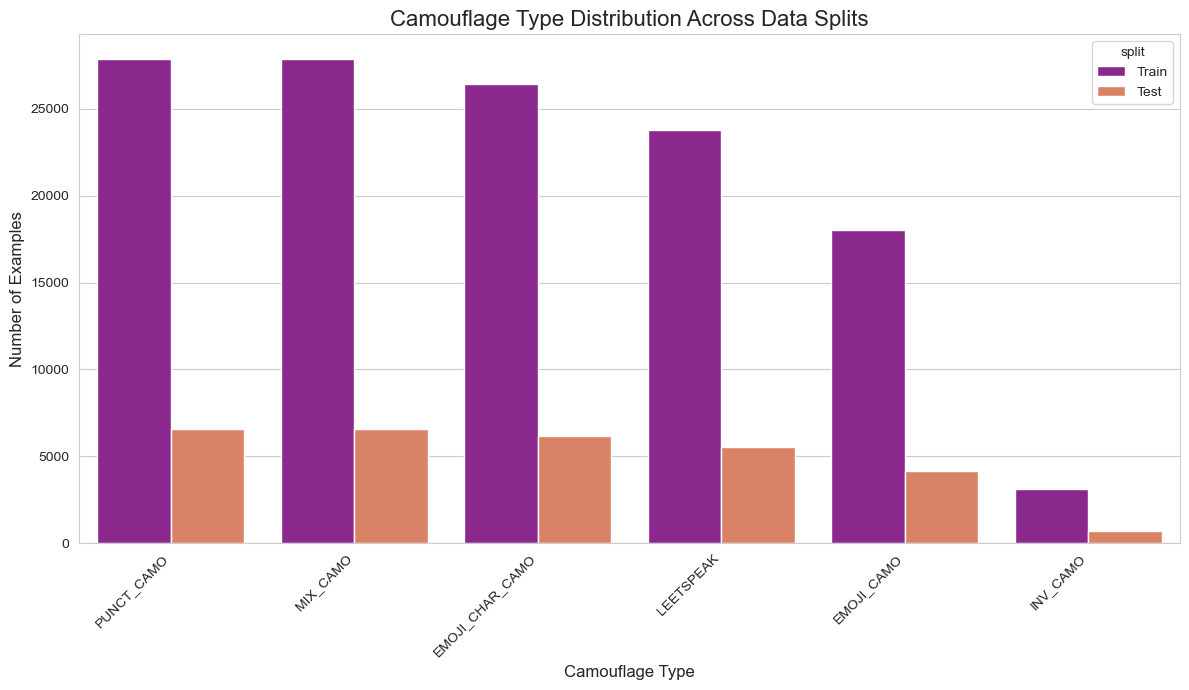


Analyzing source data to find most common offensive words...

Skipping Visualization 3: Source data file not found at 'source_data_with_offensive_words.csv'.
To generate this plot, please provide the CSV file from your data generation step.


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import os
import ast # To safely evaluate string-formatted lists

# --- Configuration ---
# Set the style for all plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 7) # Set a good default figure size

# Define file paths for the generated data
TRAIN_FILE = "augmented_train_all_combo_emoji.csv"
DEV_FILE = "augmented_dev_all_combo_emoji.csv"
TEST_FILE = "augmented_test_all_combo_emoji.csv"

# --- NEW: Define source file and output directory ---
# This is the original file containing the lists of offensive words before augmentation.
# You might need to adjust this path based on your data generation script.
SOURCE_DATA_FILE = "source_data_with_offensive_words.csv"
# This is the folder where all plots will be saved.
OUTPUT_DIR = "dataset_visualizations"

# --- Main Visualization Logic ---
def run_visualizations():
    """Loads the augmented data and generates several key plots."""
    
    # --- MODIFICATION: Create the output directory if it doesn't exist ---
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    print(f"Plots will be saved to the '{OUTPUT_DIR}/' directory.")

    try:
        # Load the datasets
        df_train = pd.read_csv(TRAIN_FILE)
        df_dev = pd.read_csv(DEV_FILE)
        df_test = pd.read_csv(TEST_FILE)
    except FileNotFoundError as e:
        print(f"Error: Could not find an augmented data file. {e}")
        print("Please make sure the augmented CSV files are in the same directory.")
        return

    # --- MODIFICATION: Combine Dev and Test sets ---
    df_train['split'] = 'Train'
    # Concatenate dev and test into a single dataframe
    df_combined_test = pd.concat([df_dev, df_test], ignore_index=True)
    # Label the entire combined set as 'Test'
    df_combined_test['split'] = 'Test'
    
    # Combine all data into a single DataFrame for easier plotting
    df_all = pd.concat([df_train, df_combined_test], ignore_index=True)

    print(f"\nLoaded a total of {len(df_all)} augmented examples.")
    print(f"  - Train split: {len(df_train)} examples")
    print(f"  - Test split (combined Dev+Test): {len(df_combined_test)} examples")

    # --- Visualization 1: Overall Distribution of Camouflage Types ---
    plt.figure()
    ax = sns.countplot(data=df_all, x='Label', order=df_all['Label'].value_counts().index, palette="viridis")
    ax.set_title("Overall Distribution of Generated Camouflage Types", fontsize=16)
    ax.set_xlabel("Camouflage Type", fontsize=12)
    ax.set_ylabel("Number of Examples", fontsize=12)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    # MODIFICATION: Save plot to the output directory
    save_path = os.path.join(OUTPUT_DIR, "1_camouflage_type_distribution.png")
    plt.savefig(save_path)
    print(f"\nGenerated plot: {save_path}")
    plt.show()

    # --- Visualization 2: Distribution Across Train/Test Splits ---
    plt.figure()
    # MODIFICATION: The 'hue' will now correctly show 'Train' and 'Test'
    ax = sns.countplot(data=df_all, x='Label', hue='split', order=df_all['Label'].value_counts().index, palette="plasma")
    ax.set_title("Camouflage Type Distribution Across Data Splits", fontsize=16)
    ax.set_xlabel("Camouflage Type", fontsize=12)
    ax.set_ylabel("Number of Examples", fontsize=12)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    # MODIFICATION: Save plot to the output directory
    save_path = os.path.join(OUTPUT_DIR, "2_distribution_by_split.png")
    plt.savefig(save_path)
    print(f"Generated plot: {save_path}")
    plt.show()

    # --- Visualization 3: Top 20 Most Frequently Augmented Words ---
    # This version reads from a source CSV file directly.
    try:
        print("\nAnalyzing source data to find most common offensive words...")
        source_df = pd.read_csv(SOURCE_DATA_FILE)
        
        # The 'extracted_offensive_words' column likely contains strings like "['word1', 'word2']".
        # We use ast.literal_eval to safely convert this string into a Python list.
        all_words = [word for sublist in source_df['extracted_offensive_words'].apply(ast.literal_eval) for word in sublist]
        
        word_counts = Counter(all_words)
        top_words_df = pd.DataFrame(word_counts.most_common(20), columns=['Word', 'Frequency'])
        
        plt.figure()
        ax = sns.barplot(data=top_words_df, y='Word', x='Frequency', palette="cividis")
        ax.set_title("Top 20 Most Frequently Augmented Offensive Words (from Source)", fontsize=16)
        ax.set_xlabel("Frequency in Source Dataset", fontsize=12)
        ax.set_ylabel("Offensive Word", fontsize=12)
        plt.tight_layout()
        # MODIFICATION: Save plot to the output directory
        save_path = os.path.join(OUTPUT_DIR, "3_top_augmented_words.png")
        plt.savefig(save_path)
        print(f"Generated plot: {save_path}")
        plt.show()

    except FileNotFoundError:
        print(f"\nSkipping Visualization 3: Source data file not found at '{SOURCE_DATA_FILE}'.")
        print("To generate this plot, please provide the CSV file from your data generation step.")
    except (KeyError, SyntaxError):
        print("\nSkipping Visualization 3: Could not process the source data file.")
        print("Please ensure it contains a column named 'extracted_offensive_words' with list-like strings.")

if __name__ == "__main__":
    run_visualizations()